# Electric Consumption and Cost

Data is retrieved from [NYC Open Data](https://data.cityofnewyork.us/Housing-Development/Electric-Consumption-And-Cost-2010-April-2020-/jr24-e7cr).

This project is divided into the following:
* Data Preparation
* Testing & Training
* PCA
* k-means
* Aggolmerate/Hierarchical
* DBSCAN
* breast_cancer data attempts

# Data Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from pandas.plotting import scatter_matrix
import mglearn

import warnings
warnings.filterwarnings('ignore')

In [2]:
ec = pd.read_csv("/Users/sheryl/GitHub/data71200su21/Project 1/dataset/electric-consumption.csv",
                                   low_memory=False)

In [3]:
ec.shape

(301317, 27)

In [4]:
ec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301317 entries, 0 to 301316
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Development Name    301193 non-null  object 
 1   Borough             301317 non-null  object 
 2   Account Name        301317 non-null  object 
 3   Location            293386 non-null  object 
 4   Meter AMR           301231 non-null  object 
 5   Meter Scope         15799 non-null   object 
 6   TDS #               299936 non-null  float64
 7   EDP                 301317 non-null  int64  
 8   RC Code             301317 non-null  object 
 9   Funding Source      301317 non-null  object 
 10  AMP #               299972 non-null  object 
 11  Vendor Name         301317 non-null  object 
 12  UMIS BILL ID        301317 non-null  int64  
 13  Revenue Month       301317 non-null  object 
 14  Service Start Date  301314 non-null  object 
 15  Service End Date    301314 non-nul

In [5]:
ec_drop0 = ec[ec != 0]

In [6]:
ec_negative = ec_drop0[ec_drop0['Current Charges'] > 0]

In [7]:
ec_dropcolumns = ec_negative.drop(["UMIS BILL ID", "Consumption (KW)", "KW Charges", "Other charges", 
                               "Bill Analyzed", "Meter Number", "AMP #", "Account Name", "Service Start Date",
                              "Service End Date", "RC Code", "Development Name", "Location", "Meter AMR", "Meter Scope",
                              "Vendor Name", "Funding Source", "Rate Class", "Revenue Month", "Estimated"], axis=1)
print(ec_dropcolumns)

         Borough  TDS #  EDP  # days  Current Charges  Consumption (KWH)  \
0          BRONX  118.0  248    33.0         15396.82           128800.0   
1          BRONX  118.0  248    30.0         14556.34           115200.0   
2          BRONX  118.0  248    29.0         13904.98           103200.0   
3          BRONX  118.0  248    31.0         14764.04           105600.0   
4          BRONX  118.0  248    28.0         13729.54            97600.0   
...          ...    ...  ...     ...              ...                ...   
301312  BROOKLYN  163.0  272    29.0          1287.71                NaN   
301313  BROOKLYN  163.0  272    29.0          1705.42                NaN   
301314  BROOKLYN  163.0  272    29.0          3782.25           101200.0   
301315  BROOKLYN  163.0  272    29.0          2541.43            68000.0   
301316  BROOKLYN  163.0  272    29.0          2967.49            79400.0   

        KWH Charges  
0           7387.97  
1           6607.87  
2           5919.55  

In [8]:
ec_new = ec_dropcolumns.dropna()
print(ec_new)

         Borough  TDS #  EDP  # days  Current Charges  Consumption (KWH)  \
0          BRONX  118.0  248    33.0         15396.82           128800.0   
1          BRONX  118.0  248    30.0         14556.34           115200.0   
2          BRONX  118.0  248    29.0         13904.98           103200.0   
3          BRONX  118.0  248    31.0         14764.04           105600.0   
4          BRONX  118.0  248    28.0         13729.54            97600.0   
...          ...    ...  ...     ...              ...                ...   
301309  BROOKLYN  163.0  272    29.0          5608.58            67600.0   
301310  BROOKLYN  163.0  272    29.0          6438.24            77600.0   
301314  BROOKLYN  163.0  272    29.0          3782.25           101200.0   
301315  BROOKLYN  163.0  272    29.0          2541.43            68000.0   
301316  BROOKLYN  163.0  272    29.0          2967.49            79400.0   

        KWH Charges  
0           7387.97  
1           6607.87  
2           5919.55  

In [9]:
#replace boroughs with numerical numbers
ec_boro = ec_new.replace({'BROOKLYN': 1, 'MANHATTAN': 4, 'BRONX': 2, 'QUEENS': 5, 'STATEN ISLAND': 6, 'FHA': 3})
print(ec_boro)

        Borough  TDS #  EDP  # days  Current Charges  Consumption (KWH)  \
0             2  118.0  248    33.0         15396.82           128800.0   
1             2  118.0  248    30.0         14556.34           115200.0   
2             2  118.0  248    29.0         13904.98           103200.0   
3             2  118.0  248    31.0         14764.04           105600.0   
4             2  118.0  248    28.0         13729.54            97600.0   
...         ...    ...  ...     ...              ...                ...   
301309        1  163.0  272    29.0          5608.58            67600.0   
301310        1  163.0  272    29.0          6438.24            77600.0   
301314        1  163.0  272    29.0          3782.25           101200.0   
301315        1  163.0  272    29.0          2541.43            68000.0   
301316        1  163.0  272    29.0          2967.49            79400.0   

        KWH Charges  
0           7387.97  
1           6607.87  
2           5919.55  
3          

In [10]:
# Brooklyn - 1
# Bronx - 2
# FHA - 3
# Manhattan - 4
# Queens - 5
# Staten Island - 6

ec_boro['Borough'].value_counts()

1    80141
4    52913
2    46969
5    20677
6     1708
3      747
Name: Borough, dtype: int64

In [11]:
#drop the frequencies of Consumption values less than 10
counts = ec_boro['Consumption (KWH)'].value_counts()
ec_final = ec_boro[~ec_boro['Consumption (KWH)'].isin(counts[counts < 10].index)]
print(ec_final)

        Borough  TDS #  EDP  # days  Current Charges  Consumption (KWH)  \
0             2  118.0  248    33.0         15396.82           128800.0   
1             2  118.0  248    30.0         14556.34           115200.0   
2             2  118.0  248    29.0         13904.98           103200.0   
3             2  118.0  248    31.0         14764.04           105600.0   
4             2  118.0  248    28.0         13729.54            97600.0   
...         ...    ...  ...     ...              ...                ...   
301309        1  163.0  272    29.0          5608.58            67600.0   
301310        1  163.0  272    29.0          6438.24            77600.0   
301314        1  163.0  272    29.0          3782.25           101200.0   
301315        1  163.0  272    29.0          2541.43            68000.0   
301316        1  163.0  272    29.0          2967.49            79400.0   

        KWH Charges  
0           7387.97  
1           6607.87  
2           5919.55  
3          

In [12]:
ec_final.describe()

,Borough,TDS #,EDP,# days,Current Charges,Consumption (KWH),KWH Charges
count,191832.000000,191832.000000,191832.000000,191832.000000,191832.000000,191832.000000,191832.000000
mean,2.442502,139.873040,434.805564,30.359877,5403.773708,44229.928886,2145.255926
std,1.499267,135.844479,185.868879,1.644027,5206.873244,41029.105579,2082.219438
min,1.000000,1.000000,200.000000,1.000000,0.310000,1.000000,0.050000
25%,1.000000,39.000000,237.000000,29.000000,1668.205000,15480.000000,709.180000
50%,2.000000,74.000000,429.000000,30.000000,4146.890000,35280.000000,1672.700000
75%,4.000000,240.000000,566.000000,31.000000,7402.150000,61200.000000,2926.590000
max,6.000000,582.000000,871.000000,152.000000,81084.020000,345600.000000,38313.270000


In [13]:
ec_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191832 entries, 0 to 301316
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Borough            191832 non-null  int64  
 1   TDS #              191832 non-null  float64
 2   EDP                191832 non-null  int64  
 3   # days             191832 non-null  float64
 4   Current Charges    191832 non-null  float64
 5   Consumption (KWH)  191832 non-null  float64
 6   KWH Charges        191832 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 11.7 MB


# Training Set

In [14]:
ec_final.keys()

Index(['Borough', 'TDS #', 'EDP', '# days', 'Current Charges',
       'Consumption (KWH)', 'KWH Charges'],
      dtype='object')

In [15]:
ec_final = ec_final.rename(columns={"Borough": "boro", "TDS #": "tds", "EDP": "edp", 
                   "# days": "days", "Current Charges": "current_charges", "Consumption (KWH)": "consumption_kwh",
                  "KWH Charges": "kwh_charges"})
print(ec_final)

        boro    tds  edp  days  current_charges  consumption_kwh  kwh_charges
0          2  118.0  248  33.0         15396.82         128800.0      7387.97
1          2  118.0  248  30.0         14556.34         115200.0      6607.87
2          2  118.0  248  29.0         13904.98         103200.0      5919.55
3          2  118.0  248  31.0         14764.04         105600.0      6057.22
4          2  118.0  248  28.0         13729.54          97600.0      5598.34
...      ...    ...  ...   ...              ...              ...          ...
301309     1  163.0  272  29.0          5608.58          67600.0      2276.77
301310     1  163.0  272  29.0          6438.24          77600.0      2613.57
301314     1  163.0  272  29.0          3782.25         101200.0      3408.42
301315     1  163.0  272  29.0          2541.43          68000.0      2290.24
301316     1  163.0  272  29.0          2967.49          79400.0      2674.19

[191832 rows x 7 columns]


In [53]:
X = ec_final["boro"]
X = X.values.reshape(-1,1)
print(X)

[[2]
 [2]
 [2]
 ...
 [1]
 [1]
 [1]]


In [54]:
y = ec_final[['consumption_kwh']]
y = y.values.reshape(-1,1)
print(y)

[[128800.]
 [115200.]
 [103200.]
 ...
 [101200.]
 [ 68000.]
 [ 79400.]]


In [55]:
print("Shape of X is: ", X.shape, ". The shape of y is:", y.shape)

Shape of X is:  (191832, 1) . The shape of y is: (191832, 1)


In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [57]:
print("Shape of original Electric Consumption dataset :", ec_final.shape)
print("Shape of X training set :", X_train.shape)
print("Shape of y training set :", y_train.shape)
print("Shape of X testing set :", X_test.shape)
print("Shape of y testing set :", y_test.shape)

Shape of original Electric Consumption dataset : (191832, 7)
Shape of X training set : (153465, 1)
Shape of y training set : (153465, 1)
Shape of X testing set : (38367, 1)
Shape of y testing set : (38367, 1)


In [58]:
print(X_train)

[[1]
 [5]
 [1]
 ...
 [1]
 [1]
 [2]]


In [59]:
print(y_train)

[[ 70080.]
 [ 41040.]
 [ 31360.]
 ...
 [180400.]
 [ 52800.]
 [ 22560.]]


# PCA (95% of Variance Captured)

In [60]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [61]:
from sklearn.decomposition import PCA

pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [120]:
# keep the first two principal components of the data
pca = PCA(n_components=0.95)
# fit PCA model to data
pca.fit(X_train)

print('-'*20 + 'Explained variance ratio' + '-'*20)
print(pca.explained_variance_ratio_.sum())

--------------------Explained variance ratio--------------------
1.0


In [62]:
explained_variance = pca.explained_variance_ratio_
print("\n",explained_variance)


 [1.]


In [63]:
pca = PCA(n_components=1)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [64]:
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

[1.]


In [65]:
X_pca2 = pca.transform(X_train)
print(X_pca2)

[[-0.96096441]
 [ 1.70870251]
 [-0.96096441]
 ...
 [-0.96096441]
 [-0.96096441]
 [-0.29354768]]


In [66]:
plt.figure(figsize=(8, 8))
mglearn.discrete_scatter(X_pca2[:,0], X_pca2[:,1], y_train)
#plt.legend(y_train, loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

IndexError: index 1 is out of bounds for axis 1 with size 1

<Figure size 576x576 with 0 Axes>

# Feature Selection

IndexError: list index out of range

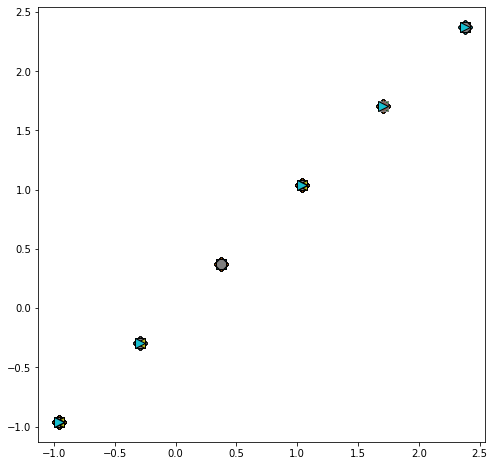

In [41]:
X_pca1 = pca.transform(X_train)

# plot first vs. second principal component, colored by class
plt.figure(figsize=(8, 8))
mglearn.discrete_scatter(X_pca1, X_pca1, y_train)
plt.legend(y_train, loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

# k-Means

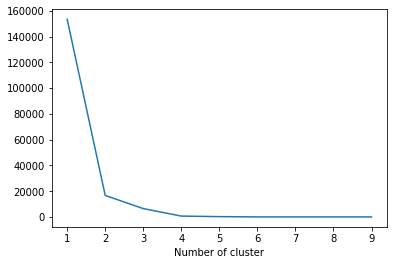

In [89]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.cluster import KMeans

inertiaVals = {}
for k in range(1, 10):
    kmeansTmp = KMeans(n_clusters=k, max_iter=1000).fit(X_train)
    inertiaVals[k] = kmeansTmp.inertia_ 
plt.figure()
plt.plot(list(inertiaVals.keys()), list(inertiaVals.values()))
plt.xlabel("Number of cluster")
plt.show()

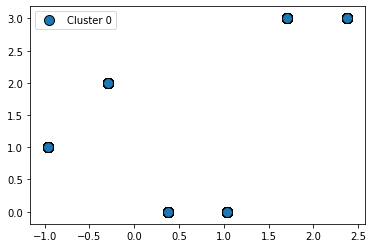

In [46]:
kmeans2 = KMeans(n_clusters=4)
kmeans2.fit(X_train)

mglearn.discrete_scatter(X_train[:, 0], kmeans2.labels_, markers='o')
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")

# Aggolmerate/Hierarchical

In [ ]:
#kernel crashes when running this code
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=2)
assignment = agg.fit_predict(X_train)

mglearn.discrete_scatter(X_train, assignment)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In [ ]:
# Import the dendrogram function and the ward clustering function from SciPy
from scipy.cluster.hierarchy import dendrogram, ward

linkage_array = ward(X_train)
dendrogram(linkage_array)


ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [7.25, 7.25], '--', c='k')
ax.plot(bounds, [4, 4], '--', c='k')

ax.text(bounds[1], 7.25, ' two clusters', va='center', fontdict={'size': 15})
ax.text(bounds[1], 4, ' three clusters', va='center', fontdict={'size': 15})
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")

# DBSCAN

Text(0, 0.5, 'Feature 1')

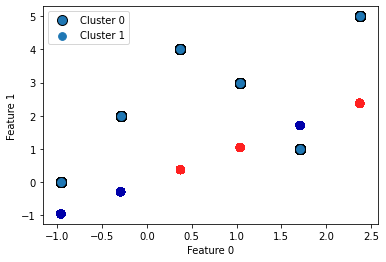

In [121]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(min_samples=5,eps=0.2)
clusters = dbscan.fit_predict(X_train)

plt.scatter(X_train, X_train, c=clusters, cmap=mglearn.cm2, s=60)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

mglearn.discrete_scatter(X_train, clusters)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

IndexError: index 1 is out of bounds for axis 1 with size 1

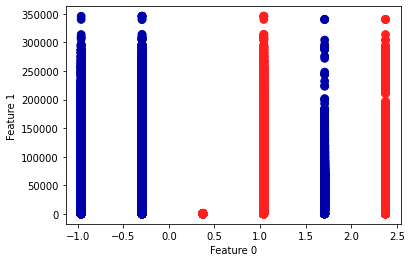

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X_train)

dbscan = DBSCAN(min_samples=5,eps=0.2)
clusters = dbscan.fit_predict(X_scaled)

# plot the cluster assignments
plt.scatter(X_scaled, y_train, c=clusters, cmap=mglearn.cm2, s=60)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

mglearn.discrete_scatter(X_scaled[:, 0], X_train[:, 1], clusters)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

ValueError: labels_true must be 1D: shape is (153465, 1)

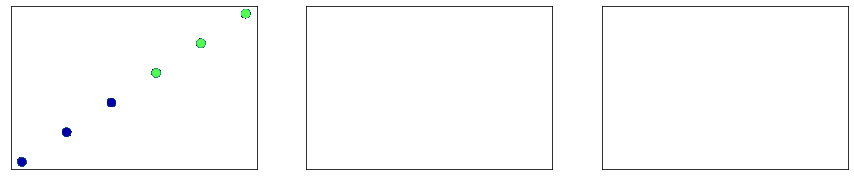

In [125]:
from sklearn.metrics.cluster import adjusted_rand_score

# Rescale the data to zero mean and unit variance
scaler = StandardScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X_train)

fig, axes = plt.subplots(1, 3, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# make a list of algorithms to use
algorithms = [KMeans(n_clusters=3),
              DBSCAN()]

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X_train))

# plot random assignment
axes[0].scatter(X_scaled, X_scaled, c=random_clusters,
                cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment - ARI: {:.2f}".format(
        adjusted_rand_score(y_train, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    # plot the cluster assignments and cluster centers
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled, X_scaled, c=clusters,
               cmap=mglearn.cm3, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__,
                                           adjusted_rand_score(y_train, clusters)))

# breast_cancer data

In [90]:
from sklearn.datasets import load_breast_cancer
breast_cancer = load_breast_cancer()
print(breast_cancer.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [91]:
bc_data = breast_cancer.data
print(bc_data)

[[1.799e+01 1.038e+01 1.228e+02 ... 2.654e-01 4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 ... 1.860e-01 2.750e-01 8.902e-02]
 [1.969e+01 2.125e+01 1.300e+02 ... 2.430e-01 3.613e-01 8.758e-02]
 ...
 [1.660e+01 2.808e+01 1.083e+02 ... 1.418e-01 2.218e-01 7.820e-02]
 [2.060e+01 2.933e+01 1.401e+02 ... 2.650e-01 4.087e-01 1.240e-01]
 [7.760e+00 2.454e+01 4.792e+01 ... 0.000e+00 2.871e-01 7.039e-02]]


In [92]:
breast_labels = breast_cancer.target
labels = np.reshape(breast_labels,(569,1))
print(labels)

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]


In [93]:
features = breast_cancer.feature_names
print(features)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [94]:
features_labels = np.append(features,'label')

In [95]:
features

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

# breast_cancer data: Testing and Training

In [96]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(breast_cancer.data, breast_cancer.target):
    bcX_train = breast_cancer.data[train_index]
    bcX_test = breast_cancer.data[test_index]
    bcy_train = breast_cancer.target[train_index]
    bcy_test = breast_cancer.target[test_index]

# Feature Selection

In [97]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(breast_cancer.data)
bcX_scaled = scaler.transform(breast_cancer.data)

Text(0, 0.5, 'Second principal component')

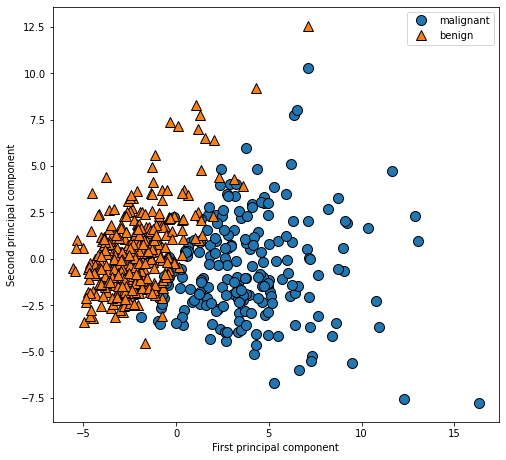

In [98]:
from sklearn.decomposition import PCA
# keep the first two principal components of the data
pca2 = PCA(n_components=2)
# fit PCA model to data
pca2.fit(bcX_scaled)

# transform data onto the first two principal components
bcX_pca2 = pca2.transform(bcX_scaled)

# plot first vs. second principal component, colored by class
plt.figure(figsize=(8, 8))
mglearn.discrete_scatter(bcX_pca2[:, 0], bcX_pca2[:, 1], breast_cancer.target)
plt.legend(breast_cancer.target_names, loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

Text(0, 0.5, 'Principal components')

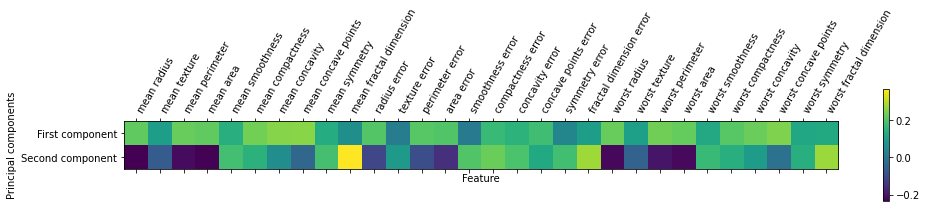

In [99]:
plt.matshow(pca2.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(breast_cancer.feature_names)),
           breast_cancer.feature_names, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components")

# 95% of Variance

In [118]:
# keep the first two principal components of the data
pca4 = PCA(n_components=0.95)
# fit PCA model to data
pca4.fit(bcX_scaled)

print('-'*20 + 'Explained variance ratio' + '-'*20)
print(pca4.explained_variance_ratio_.sum())

--------------------Explained variance ratio--------------------
0.9515688143366665


In [102]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=0).fit(bcX_train, bcy_train)

print("Accuracy on training set: {:.2f}".format(model.score(bcX_train, bcy_train)))
print("Accuracy on test set: {:.2f}".format(model.score(bcX_test, bcy_test)))

Accuracy on training set: 1.00
Accuracy on test set: 0.91


In [116]:
from sklearn.neighbors import KNeighborsRegressor
model=KNeighborsRegressor(n_neighbors=2).fit(bcX_train, bcy_train)

print("Training set R^2: {:.2f}".format(model.score(bcX_train, bcy_train)))
print("Test set R^2: {:.2f}".format(model.score(bcX_test, bcy_test)))

Training set R^2: 0.91
Test set R^2: 0.71


# breast_cancer data: k-Means

Text(0, 0.5, 'Feature 1')

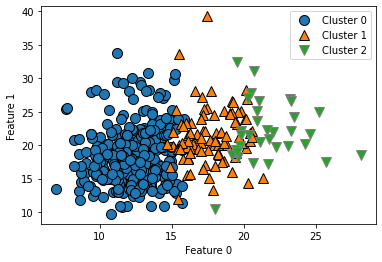

In [104]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(bcX_train)
assignments=kmeans.labels_

mglearn.discrete_scatter(bcX_train[:, 0], bcX_train[:, 1], assignments)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

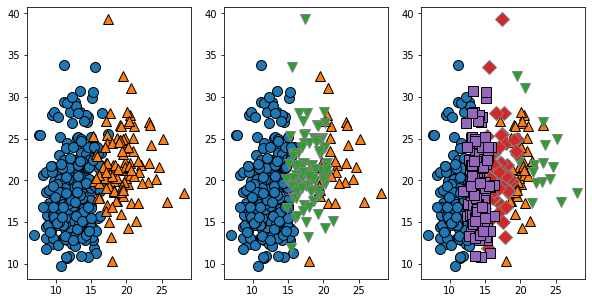

In [105]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

kmeans = KMeans(n_clusters=2)
kmeans.fit(bcX_train)
assignments = kmeans.labels_

mglearn.discrete_scatter(bcX_train[:, 0], bcX_train[:, 1], assignments, ax=axes[0])

kmeans = KMeans(n_clusters=3)
kmeans.fit(bcX_train)
assignments=kmeans.labels_

mglearn.discrete_scatter(bcX_train[:, 0], bcX_train[:, 1], assignments, ax=axes[1])

kmeans = KMeans(n_clusters=5)
kmeans.fit(bcX_train)
assignments = kmeans.labels_

mglearn.discrete_scatter(bcX_train[:, 0], bcX_train[:, 1], assignments, ax=axes[2])

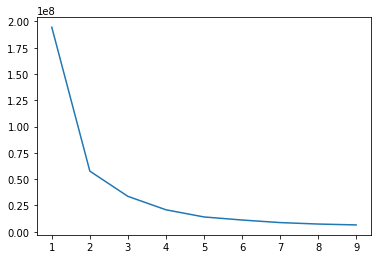

In [106]:
inertiaVals = {}
for k in range(1, 10):
    kmeansTmp = KMeans(n_clusters=k, max_iter=1000).fit(bcX_train)
    inertiaVals[k] = kmeansTmp.inertia_ 
plt.figure()
plt.plot(list(inertiaVals.keys()), list(inertiaVals.values()))
plt.show()

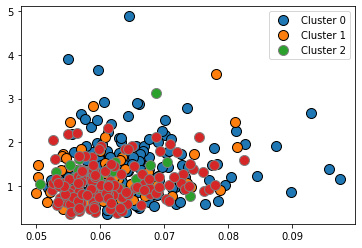

In [107]:
kmeans2 = KMeans(n_clusters=4)
kmeans2.fit(bcX_train)

mglearn.discrete_scatter(bcX_train[:, 9], bcX_train[:, 11], kmeans2.labels_, markers='o')
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")


In [131]:
print(kmeans2.score(bcX_train))

-20898984.64052836


# breast_cancer data: Agglomerative Clustering

Text(0, 0.5, 'Feature 1')

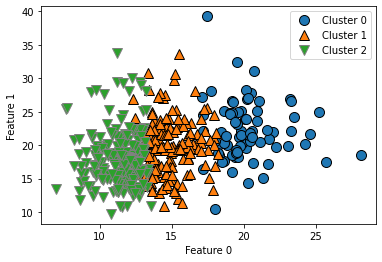

In [108]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=3)
assignment = agg.fit_predict(bcX_train)

mglearn.discrete_scatter(bcX_train[:, 0], bcX_train[:, 1], assignment)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Text(0, 0.5, 'Cluster distance')

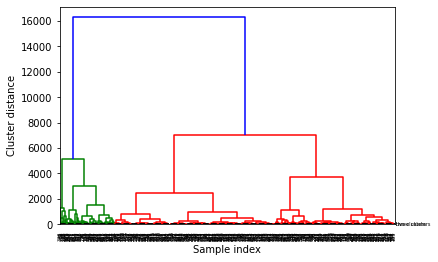

In [136]:
from scipy.cluster.hierarchy import dendrogram, ward

linkage_array = ward(bcX_train)
dendrogram(linkage_array, leaf_rotation=90)

ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [7.25, 7.25], '--', c='k')
ax.plot(bounds, [4, 4], '--', c='k')

ax.text(bounds[1], 7.25, ' two clusters', va='center', fontdict={'size': 5})
ax.text(bounds[1], 4, ' three clusters', va='center', fontdict={'size': 5})
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")

# breast_cancer data: DBSCAN

Text(0, 0.5, 'Feature 1')

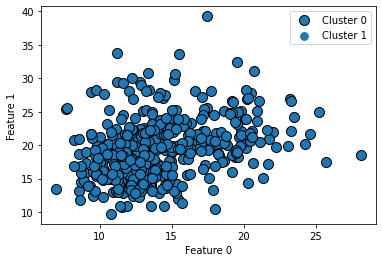

In [148]:
dbscan = DBSCAN(min_samples=5000,eps=0.3)
clusters = dbscan.fit_predict(bcX_train)

plt.scatter(bcX_train[:, 0], bcX_train[:, 1], c=clusters, cmap=mglearn.cm2, s=60)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

mglearn.discrete_scatter(bcX_train[:, 0], bcX_train[:, 1], clusters)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Text(0, 0.5, 'Feature 1')

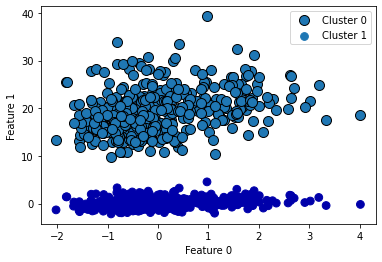

In [147]:
scaler = StandardScaler()
scaler.fit(bcX_train)
bcX_scaled = scaler.transform(bcX_train)

dbscan = DBSCAN(min_samples=1500,eps=0.3)
clusters = dbscan.fit_predict(bcX_scaled)

plt.scatter(bcX_scaled[:, 0], bcX_scaled[:, 1], c=clusters, cmap=mglearn.cm2, s=60)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

mglearn.discrete_scatter(bcX_scaled[:, 0], bcX_train[:, 1], clusters)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

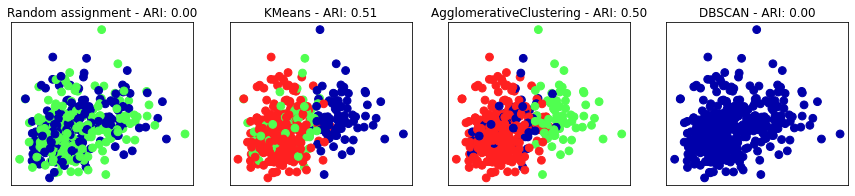

In [149]:
scaler = StandardScaler()
scaler.fit(bcX_train)
bcX_scaled = scaler.transform(bcX_train)

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

algorithms = [KMeans(n_clusters=3), AgglomerativeClustering(n_clusters=3),
              DBSCAN()]

random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(bcX_train))

axes[0].scatter(bcX_scaled[:, 0], bcX_scaled[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment - ARI: {:.2f}".format(
        adjusted_rand_score(bcy_train, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(bcX_scaled)
    ax.scatter(bcX_scaled[:, 0], bcX_scaled[:, 1], c=clusters,
               cmap=mglearn.cm3, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__,
                                           adjusted_rand_score(bcy_train, clusters)))